
# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

<center>
<img 
     src="http://www2.famaf.unc.edu.ar/~efernandez/egeo/img/logos/famaf.jpg" 
     alt="Drawing" 
     style="width:30%;"
/>
</center>

### Universidad Nacional de Córdoba
---

## Practico
### Curación y Exploración de Datos

En la siguiente notebook, se presentará la consigna a seguir para el segundo práctico de la materia Exploración y Curación. El objetivo consiste en identificar e implementar los pasos necesarios para la limpieza de la base de datos, así como también analizar cruces de datos con mayor profundidad y validando el sentido lógico. 

Dataset: [here](https://drive.google.com/file/d/1wCNrWQbUd_bh1mdjZ-dg3g9y0r02JyQN/view?usp=sharing)

## Importación de Librerías

In [1]:
!pip install sklearn

You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install missingno

You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


In [3]:
import pyarrow
import fastparquet
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import missingno as msno

pd.set_option('display.max_columns', None)

## Lectura de Datasets

In [4]:
df = pd.read_parquet("cupones_ds.parquet")

In [5]:
df

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,fecha_carga_sistema_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,tipo_prestamo_movimiento,codigo_contable_movimiento,local_venta_producto,nombre_local_histo,marca_debito_automatico,fecha_extraccion_movimiento,id_comercio_otras_marcas_movimiento,fecha_nacimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo
0,0001686b52949b5461ffcbc766687e45031,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,6.24,6.24,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1959-07-18,Divorciado/a,Hombre,Argentina,BUENOS AIRES,LA TABLADA,1766.0,LA TABLADA,2012-12-11,EMP.DE COMERCIO,SECUNDARIOS,Propia
1,000220fa96ec5af89817894033f8099c547,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,17.73,17.73,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1991-06-28,Sin Datos,Mujer,Argentina,MENDOZA,VA.NVA. DE GUAYMALLEN,5521.0,GLLEN,2020-06-10,SIN DATOS,None,None
2,0002be202de47dfae9cc2304d91161be595,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,6.18,6.18,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1992-07-29,Soltero/a,Mujer,Argentina,BUENOS AIRES,SANTA TERESITA,7107.0,SANTA TERESITA,2012-09-13,SIN DATOS,PRIMARIOS,Otros
3,000e137d0af42e193be1ff670c00d4d1506,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,2.83,2.83,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1980-11-01,Soltero/a,Hombre,Argentina,SANTA FE,SAN LORENZO,2200.0,BOUCHARD,2008-01-15,EMP.DE COMERCIO,SECUNDARIOS,Propia
4,0009d010e4faf69552a814a33832b185877,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,2.38,2.38,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1984-03-08,Soltero/a,Mujer,Argentina,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES,1019.0,SAN NICOLAS,2013-06-06,EMP.DE COMERCIO,UNIVERSITARIOS,Alquilada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4092072,00087cefbeb57961569988d7403d45a8135,0,30093930,TARJETA NARANJA TUCUMAN CRISOS,373205,0,PL,1,3,1,2021-03-10,2021-02-03,2021-02-03,2021-02-03,2.29,2.29,0.0,0.0,0.0,0.0,0.0,0,None,2599,30093930,TARJETA NARANJA TUCUMAN CRISOSTOMO,0,NaN,0,1950-09-05,Casado/a,Mujer,Argentina,TUCUMAN,TUCUMAN,4000.0,MZ.3-TORRE A-24 DE SETIEMBRE-TUCUMAN,2016-01-06,SIN DATOS,SECUNDARIOS,None
4092073,0007e89e7180b18b18951a4c9de5419f943,0,30095787,TARJETA NARANJA SAN ISIDRO,210118,0,PL,1,22,1,2021-02-10,2021-01-25,2021-01-25,2021-01-19,229.90,229.90,0.0,0.0,0.0,0.0,0.0,0,None,309,30095787,TARJETA NARANJA SAN ISIDRO,0,NaN,0,1991-10-16,Sin Datos,Mujer,Argentina,BUENOS AIRES,OLIVOS (Buenos Aires),1636.0,VICENTE LOPEZ,2018-10-08,SIN DATOS,None,None
4092074,00015797a6f53e90f66ae237a1157054062,0,30096987,TARJETA NARANJA GRAL ALVEAR,760582,0,PL,1,3,1,2020-10-10,2020-09-02,2020-09-02,2020-09-02,4.64,4.64,0.0,0.0,0.0,0.0,0.0,0,None,2599,30096987,TARJETA NARANJA GRAL ALVEAR,0,NaN,0,1960-06-05,Divorciado/a,Mujer,Argentina,MENDOZA,GENERAL ALVEAR,5620.0,Y EVA DUARTE,2019-08-06,SIN DATOS,PRIMARIOS,Propia
4092075,00015797a6f53e90f66ae237a1157054062,0,30096987,TARJETA NARANJA GRAL ALVEAR,761648,0,PL,1,3,1,2020-12-10,2020-11-02,2020-11-02,2020-11-02,12.22,12.22,0.0,0.0,0.0,0.0,0.0,0,None,2599,30

## 1. Curación
Con el objetivo de preparar los datos que alimentarán futuros modelos de aprendizaje automático

* Asegurar IDs únicos
  > Ejm. `id_comercio_movimiento` le corresponde un mismo `nombre_comercio_histo`?
* Asegurar que el codigo postal tenga el tipo de datos correcto.
* Tratamiento de valores Sensibles
  > Ejm. cuando se tienen datos como el DNI, CUIL o Nro de Tarjetas correponde a datos confidenciales
  - Codifcar los valores usando el algoritmo `sha256` con la libreria `hashlib`
* Reemplazar caracteres especiales. Ejm
  ```
  ñ. Ñ. ~. ç. Ç. á. é. í. ó. ú. Á. É. Í. Ó. Ú. ü. Ü.
  @. ¡ ! ¿ ? ⁄. \. °. —. (. ) [. ] {. } 〈. 〉 ‹ › <. > 
  〔. 〕 « » ¹. ². ³ … ˜. §. ¶.  †. “ ” ∞. µ. à.
  ```
* Asegurar que las fechas tengan el formato ISO 8601, `YYYY-MM-DD`
* Agrupar valores de `cargo_descripcion_histo`.
  > Ejm. si tenemos un valor con`vigilador` y otro `sereno`, estos corresponden a una misma categoria., 

In [6]:
df.columns

Index(['dni_titular_movimiento', 'moneda_movimiento', 'id_comercio_movimiento',
       'nombre_comercio_histo', 'numero_cupon_movimiento',
       'debito_credito_movimiento', 'producto_naranja_movimiento',
       'codigo_empresa_movimiento', 'tipo_producto_tarjeta_movimiento',
       'plan_movimiento', 'fecha_vto_cupon_movimiento',
       'fecha_presentacion_movimiento', 'fecha_cupon_movimiento',
       'fecha_carga_sistema_movimiento', 'monto_compra_movimiento',
       'importe_cuota_movimiento', 'interes_movimiento',
       'cargo_adm_seguro_movimiento', 'cargo_otorgamiento_movimiento',
       'cargo_seguro_vida_movimiento', 'cargo_administrativo_movimiento',
       'seleccionado_ng', 'tipo_prestamo_movimiento',
       'codigo_contable_movimiento', 'local_venta_producto',
       'nombre_local_histo', 'marca_debito_automatico',
       'fecha_extraccion_movimiento', 'id_comercio_otras_marcas_movimiento',
       'fecha_nacimiento', 'estado_civil_descripcion', 'sexo_descripcion',
       

## Asegurar IDs únicos

In [7]:
df_nar = df

In [8]:
df_nar

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,fecha_carga_sistema_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,tipo_prestamo_movimiento,codigo_contable_movimiento,local_venta_producto,nombre_local_histo,marca_debito_automatico,fecha_extraccion_movimiento,id_comercio_otras_marcas_movimiento,fecha_nacimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo
0,0001686b52949b5461ffcbc766687e45031,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,6.24,6.24,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1959-07-18,Divorciado/a,Hombre,Argentina,BUENOS AIRES,LA TABLADA,1766.0,LA TABLADA,2012-12-11,EMP.DE COMERCIO,SECUNDARIOS,Propia
1,000220fa96ec5af89817894033f8099c547,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,17.73,17.73,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1991-06-28,Sin Datos,Mujer,Argentina,MENDOZA,VA.NVA. DE GUAYMALLEN,5521.0,GLLEN,2020-06-10,SIN DATOS,None,None
2,0002be202de47dfae9cc2304d91161be595,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,6.18,6.18,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1992-07-29,Soltero/a,Mujer,Argentina,BUENOS AIRES,SANTA TERESITA,7107.0,SANTA TERESITA,2012-09-13,SIN DATOS,PRIMARIOS,Otros
3,000e137d0af42e193be1ff670c00d4d1506,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,2.83,2.83,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1980-11-01,Soltero/a,Hombre,Argentina,SANTA FE,SAN LORENZO,2200.0,BOUCHARD,2008-01-15,EMP.DE COMERCIO,SECUNDARIOS,Propia
4,0009d010e4faf69552a814a33832b185877,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,2.38,2.38,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1984-03-08,Soltero/a,Mujer,Argentina,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES,1019.0,SAN NICOLAS,2013-06-06,EMP.DE COMERCIO,UNIVERSITARIOS,Alquilada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4092072,00087cefbeb57961569988d7403d45a8135,0,30093930,TARJETA NARANJA TUCUMAN CRISOS,373205,0,PL,1,3,1,2021-03-10,2021-02-03,2021-02-03,2021-02-03,2.29,2.29,0.0,0.0,0.0,0.0,0.0,0,None,2599,30093930,TARJETA NARANJA TUCUMAN CRISOSTOMO,0,NaN,0,1950-09-05,Casado/a,Mujer,Argentina,TUCUMAN,TUCUMAN,4000.0,MZ.3-TORRE A-24 DE SETIEMBRE-TUCUMAN,2016-01-06,SIN DATOS,SECUNDARIOS,None
4092073,0007e89e7180b18b18951a4c9de5419f943,0,30095787,TARJETA NARANJA SAN ISIDRO,210118,0,PL,1,22,1,2021-02-10,2021-01-25,2021-01-25,2021-01-19,229.90,229.90,0.0,0.0,0.0,0.0,0.0,0,None,309,30095787,TARJETA NARANJA SAN ISIDRO,0,NaN,0,1991-10-16,Sin Datos,Mujer,Argentina,BUENOS AIRES,OLIVOS (Buenos Aires),1636.0,VICENTE LOPEZ,2018-10-08,SIN DATOS,None,None
4092074,00015797a6f53e90f66ae237a1157054062,0,30096987,TARJETA NARANJA GRAL ALVEAR,760582,0,PL,1,3,1,2020-10-10,2020-09-02,2020-09-02,2020-09-02,4.64,4.64,0.0,0.0,0.0,0.0,0.0,0,None,2599,30096987,TARJETA NARANJA GRAL ALVEAR,0,NaN,0,1960-06-05,Divorciado/a,Mujer,Argentina,MENDOZA,GENERAL ALVEAR,5620.0,Y EVA DUARTE,2019-08-06,SIN DATOS,PRIMARIOS,Propia
4092075,00015797a6f53e90f66ae237a1157054062,0,30096987,TARJETA NARANJA GRAL ALVEAR,761648,0,PL,1,3,1,2020-12-10,2020-11-02,2020-11-02,2020-11-02,12.22,12.22,0.0,0.0,0.0,0.0,0.0,0,None,2599,30

In [9]:
df_nar['id_comercio_movimiento'].value_counts() # 3833 valores unicos para id_comercio

958705120    464301
20099902     415104
20089993     359283
20099745     239775
20099760     194994
              ...  
380028770        15
115052555        15
840017948        15
20101264         14
64194852          5
Name: id_comercio_movimiento, Length: 3833, dtype: int64

In [10]:
# Aca deberia haber 2 'TARJETA NARANJA SUBTE'

df[df['nombre_comercio_histo'].str.contains('TARJETA NARANJA SUBTE')] \
                                        [['id_comercio_movimiento','nombre_comercio_histo']] \
                                        .drop_duplicates()

,id_comercio_movimiento,nombre_comercio_histo
22913,10099033,TARJETA NARANJA SUBTE
97058,10099033,TARJETA NARANJA SUBTE


In [11]:
# Reagrupar los comercios que tienen mas de un nombre y concatenar todos sus nombres

df_nar.nombre_comercio_histo = df_nar.nombre_comercio_histo.str.strip()

df_unicos = (
    df_nar[["id_comercio_movimiento", "nombre_comercio_histo"]].drop_duplicates()
        .groupby("id_comercio_movimiento")
        .sum()
).reset_index()

In [12]:
df_unicos = df_unicos.rename(columns={'nombre_comercio_histo':'nombre_comercio_concat'})
df_unicos

,id_comercio_movimiento,nombre_comercio_concat
0,10099033,TARJETA NARANJA SUBTE
1,10099058,TARJETA NARANJA SUCRE
2,10099814,TARJETA NARANJA SAN VICENTE
3,20080001,PAGO ANULADO POR VERIFICACION
4,20089993,IMPUESTO SELLOS
...,...,...
3828,991085968,PUERTO TERNURAS
3829,991097830,PEQUE&OS SUE&OS
3830,991108260,DISCO SM 156
3831,991108624,JUMBO MOR�N


In [13]:
# Unimos con dataframe original agregando la columna nueva con relacion 1:1 con el id

df_nar = df_nar.merge(df_unicos, on='id_comercio_movimiento', how='inner')

In [14]:
# Relacion 1:1 entre id_comercio_movimiento y la columna nueva con los nombres concatenados

df_nar[['id_comercio_movimiento', 'nombre_comercio_concat']].drop_duplicates() \
.groupby(['id_comercio_movimiento']).count() # Deberia dar 3833 que es la cantidad de ids unicos

,nombre_comercio_concat
id_comercio_movimiento,
10099033,1
10099058,1
10099814,1
20080001,1
20089993,1
...,...
991085968,1
991097830,1
991108260,1


El dataframe contiene una relacion 1:N correspondiente a id_comercio y a nombre_comercio. Estudiando casos donde esto ocurre, vimos que se debe a dos razones. Por un lado, los nombres pueden venir con caracteres especiales distintos para cada caso, causando que se identifiquen como distintos. Por otro lado, se debe a que un mismo id_comercio puede haber cambiado el nombre para distintos pagos, generando multiples nombres para un mismo id.

Para los casos donde el nombre viene con caracteres especiales, se aplica la funcion ´strip()´ que se encarga de eliminarlos. Para los casos donde los nombres si difieren, reagrupamos los casos donde hay distintos nombres y los concatenamos en una nueva columna ´nombre_comercio_concat´. Esto provoca que para los casos donde hay un unico nombre para un id, el valor quedaria igual al de la columna nombre_comercio_histo; en cambio, para los casos que si hay nombres distintos, quedara el nombre concatenado de todos los nombres asociados a ese id originalmente. De esta manera se pierde la diferencia entre los distintos nombres asociados a ese id pero se gana la relacion 1:1 entre id y nombre.

In [15]:
# Caso donde tenemos 4 nombres asociados a un mismo id, y el resultado luego de la transformacion realizada

df_nar[df_nar['id_comercio_movimiento'] == 262002246][['id_comercio_movimiento', 'nombre_comercio_histo', 'nombre_comercio_concat']]

,id_comercio_movimiento,nombre_comercio_histo,nombre_comercio_concat
3901719,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3901720,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3901721,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3901722,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3901723,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
...,...,...,...
3903094,262002246,ATMCIASEG,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3903095,262002246,ATMCIASEG,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3903096,262002246,ATMCIASEG,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3903097,262002246,ATMCIASEG,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...


## Asegurar el tipo de dato de codigo postal

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4092077 entries, 0 to 4092076
Data columns (total 41 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   dni_titular_movimiento               object 
 1   moneda_movimiento                    int64  
 2   id_comercio_movimiento               int64  
 3   nombre_comercio_histo                object 
 4   numero_cupon_movimiento              int64  
 5   debito_credito_movimiento            int64  
 6   producto_naranja_movimiento          object 
 7   codigo_empresa_movimiento            int64  
 8   tipo_producto_tarjeta_movimiento     int64  
 9   plan_movimiento                      int64  
 10  fecha_vto_cupon_movimiento           object 
 11  fecha_presentacion_movimiento        object 
 12  fecha_cupon_movimiento               object 
 13  fecha_carga_sistema_movimiento       object 
 14  monto_compra_movimiento              float64
 15  importe_cuota_movimiento        

In [17]:
df.domicilio_codigo_postal = df[df['domicilio_codigo_postal'].isna()!=True]['domicilio_codigo_postal'].apply(int).apply(str)

In [18]:
df.domicilio_codigo_postal # OBject???

0          1766
1          5521
2          7107
3          2200
4          1019
           ... 
4092072    4000
4092073    1636
4092074    5620
4092075    5620
4092076    5620
Name: domicilio_codigo_postal, Length: 4092077, dtype: object

En el dataset original la columna de codigo postal viene en formato float64. Considerando que deberia ser una variable categorica, conviene que el tipo sea ´str´.

## 2. Data enrichment
* obtener edad usando la columna `fecha_nacimiento` y `fecha_cupon_movimiento`
* obtener antiguedad usando la columna `fecha_de_ingreso_histo` y `fecha_cupon_movimiento` en termino de meses
* usando la columna `nombre_comercio_histo` crear una nueva columna clasificando el tipo de "comercio". Ejemplo 
   ```
     COMISION POR MANTENIM.DE CTA., IMPUESTO SELLOS, INT.PAGO FUERA TERMINO ------> Categoria A
     MERCADO PAGO, DESPEGAR.COM                                             ------> Categoria B
   ```
   > Crear un minimo de 5 categorias
* se puede aplicar el proceso anterior a la columna `nombre_local_histo` y `cargo_descripcion_histo`. Aportaria informacion relevante?

### Cálculo de la edad de la persona

## 3. Exploración

* Analisis de valores Nulos
  - Existen columnas en donde se prodria hacer imputacion de valores? Si es asi, imputar los valores.
  - Para aquellos en donde no aplique lo primero, conviene eliminarlos o agruparlos como otro valor?
* Identificar valores atípicos.
  * Para variables numericas, analisis de outliers. En que caso se pueden eliminar estos valores?
  * Para variables categoricas, se pueden agrupar estos valores en una nueva categoria?
    > Ejm. `cargo_descripcion_histo`
  * Para fechas. existen fechas atipicas?
    > Ejm. Una fecha con el valor `2021-12-03`, sabiendo que el dataset deberia tener  datos entre julio 2020 y mayo 2021 
* Se puede normalizar la antiguedad y/o `monto_compra_movimiento`?
* Usando la edad y la antiguerdad hacer una analisis de PCA junto con la variables `monto_compra_movimiento`
  > pueden usar las 3 variables o hacer un analisis edad - monto y antiguedad - monto.

### Análisis de Datos Nulos

In [19]:
df.shape

(4092077, 41)

In [20]:
missing_values_count = df.isna().sum()
missing_values_count

dni_titular_movimiento                       0
moneda_movimiento                            0
id_comercio_movimiento                       0
nombre_comercio_histo                        0
numero_cupon_movimiento                      0
debito_credito_movimiento                    0
producto_naranja_movimiento                  0
codigo_empresa_movimiento                    0
tipo_producto_tarjeta_movimiento             0
plan_movimiento                              0
fecha_vto_cupon_movimiento                   0
fecha_presentacion_movimiento                0
fecha_cupon_movimiento                       0
fecha_carga_sistema_movimiento         1404647
monto_compra_movimiento                      0
importe_cuota_movimiento                     0
interes_movimiento                           0
cargo_adm_seguro_movimiento                  0
cargo_otorgamiento_movimiento                0
cargo_seguro_vida_movimiento                 0
cargo_administrativo_movimiento              0
seleccionado_

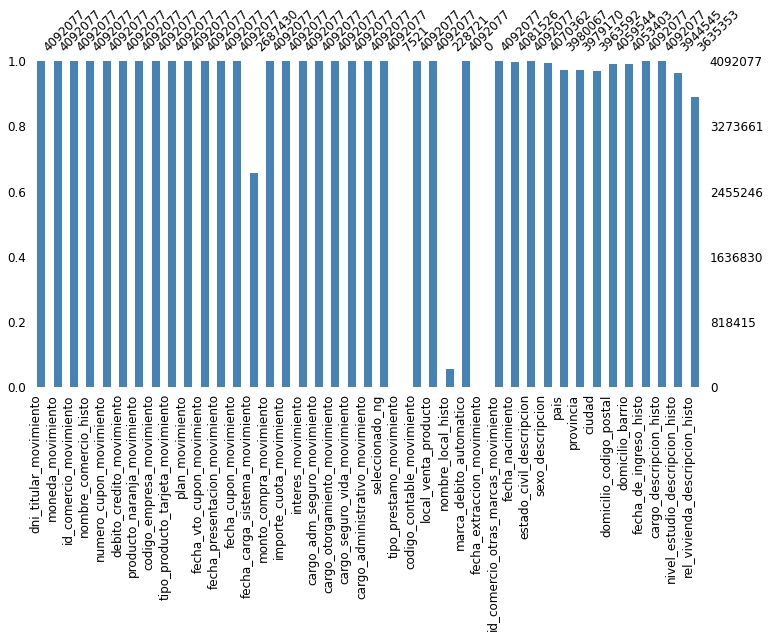

In [21]:
ax = msno.bar(df,figsize=(12, 6), fontsize=12, color='steelblue')
ax.tick_params('x', rotation=90)

In [22]:
# how many total missing values do we have?
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
(total_missing/total_cells) * 100

8.645956445148789

Las variables tipo_prestamo_movimiento, nombre_local_histo y fecha_extraccion_movimiento poseen una pérdida muy alta de valores (fecha extracción tiene todos valores nulos), por lo cuál la mejor decisión seria no tenerlas en cuenta en los siguientes análisis.

In [23]:
df_drop = df.drop(columns = ['tipo_prestamo_movimiento','nombre_local_histo','fecha_extraccion_movimiento']) 
df_drop.shape

(4092077, 38)

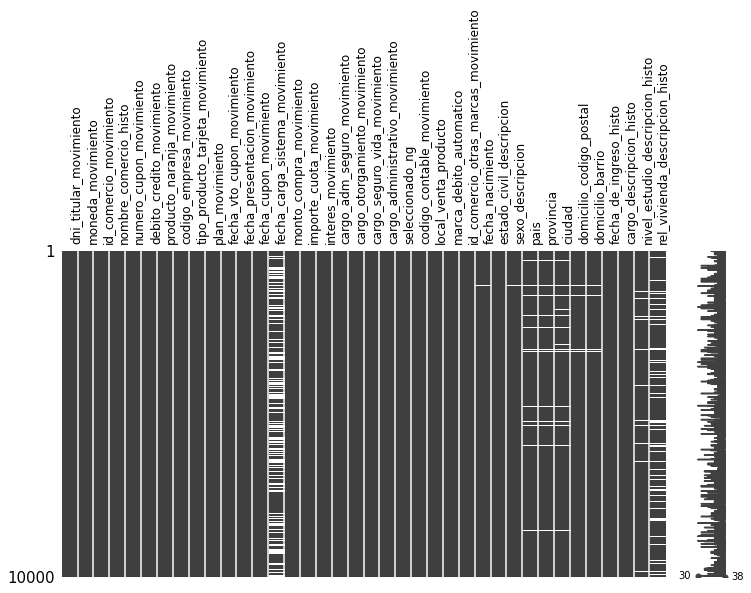

In [24]:
#usamos sample porque da error con todo el datas
df_ms = df_drop.sample(10000)
ax = msno.matrix(df_ms,figsize=(12, 6),fontsize=12)
ax.tick_params('x', rotation=90)

Se puede observar cierta sistematicidad en la pérdida de valores relacionados a datos personales de los clientes. A continuación procedemos a analizar cada columna con valores faltantes.

**Datos Faltantes Personales de los clientes** 

In [25]:
df_faltante_fech= pd.DataFrame(df_drop[df_drop['fecha_nacimiento'].isna()])
df_faltante_fech.isna().sum()

dni_titular_movimiento                     0
moneda_movimiento                          0
id_comercio_movimiento                     0
nombre_comercio_histo                      0
numero_cupon_movimiento                    0
debito_credito_movimiento                  0
producto_naranja_movimiento                0
codigo_empresa_movimiento                  0
tipo_producto_tarjeta_movimiento           0
plan_movimiento                            0
fecha_vto_cupon_movimiento                 0
fecha_presentacion_movimiento              0
fecha_cupon_movimiento                     0
fecha_carga_sistema_movimiento          2484
monto_compra_movimiento                    0
importe_cuota_movimiento                   0
interes_movimiento                         0
cargo_adm_seguro_movimiento                0
cargo_otorgamiento_movimiento              0
cargo_seguro_vida_movimiento               0
cargo_administrativo_movimiento            0
seleccionado_ng                            0
codigo_con

In [26]:
df_faltante_fech.dni_titular_movimiento.value_counts()

000cde1ad5d8114e7a5dd977930b8835659    8481
000650e8144e3a42d47a21aee9e48f34804    1380
000b0d85fa8a959e2133328830fff990443     690
Name: dni_titular_movimiento, dtype: int64

In [27]:
dni859 = df_drop[(df_drop["dni_titular_movimiento"] =="000cde1ad5d8114e7a5dd977930b8835659")]
dni859.isna().sum()

dni_titular_movimiento                    0
moneda_movimiento                         0
id_comercio_movimiento                    0
nombre_comercio_histo                     0
numero_cupon_movimiento                   0
debito_credito_movimiento                 0
producto_naranja_movimiento               0
codigo_empresa_movimiento                 0
tipo_producto_tarjeta_movimiento          0
plan_movimiento                           0
fecha_vto_cupon_movimiento                0
fecha_presentacion_movimiento             0
fecha_cupon_movimiento                    0
fecha_carga_sistema_movimiento         1380
monto_compra_movimiento                   0
importe_cuota_movimiento                  0
interes_movimiento                        0
cargo_adm_seguro_movimiento               0
cargo_otorgamiento_movimiento             0
cargo_seguro_vida_movimiento              0
cargo_administrativo_movimiento           0
seleccionado_ng                           0
codigo_contable_movimiento      

In [28]:
dni804 = df_drop[(df_drop["dni_titular_movimiento"] =="000650e8144e3a42d47a21aee9e48f34804")]
dni804.isna().sum()

dni_titular_movimiento                    0
moneda_movimiento                         0
id_comercio_movimiento                    0
nombre_comercio_histo                     0
numero_cupon_movimiento                   0
debito_credito_movimiento                 0
producto_naranja_movimiento               0
codigo_empresa_movimiento                 0
tipo_producto_tarjeta_movimiento          0
plan_movimiento                           0
fecha_vto_cupon_movimiento                0
fecha_presentacion_movimiento             0
fecha_cupon_movimiento                    0
fecha_carga_sistema_movimiento         1104
monto_compra_movimiento                   0
importe_cuota_movimiento                  0
interes_movimiento                        0
cargo_adm_seguro_movimiento               0
cargo_otorgamiento_movimiento             0
cargo_seguro_vida_movimiento              0
cargo_administrativo_movimiento           0
seleccionado_ng                           0
codigo_contable_movimiento      

In [29]:
dni443 = df_drop[(df_drop["dni_titular_movimiento"] =="000b0d85fa8a959e2133328830fff990443")]
dni443.isna().sum()

dni_titular_movimiento                   0
moneda_movimiento                        0
id_comercio_movimiento                   0
nombre_comercio_histo                    0
numero_cupon_movimiento                  0
debito_credito_movimiento                0
producto_naranja_movimiento              0
codigo_empresa_movimiento                0
tipo_producto_tarjeta_movimiento         0
plan_movimiento                          0
fecha_vto_cupon_movimiento               0
fecha_presentacion_movimiento            0
fecha_cupon_movimiento                   0
fecha_carga_sistema_movimiento           0
monto_compra_movimiento                  0
importe_cuota_movimiento                 0
interes_movimiento                       0
cargo_adm_seguro_movimiento              0
cargo_otorgamiento_movimiento            0
cargo_seguro_vida_movimiento             0
cargo_administrativo_movimiento          0
seleccionado_ng                          0
codigo_contable_movimiento               0
local_venta

In [30]:
df_drop[(df_drop["dni_titular_movimiento"] =="000b0d85fa8a959e2133328830fff990443") | 
        (df_drop["dni_titular_movimiento"] =="000650e8144e3a42d47a21aee9e48f34804") | 
        (df_drop["dni_titular_movimiento"] =="000cde1ad5d8114e7a5dd977930b8835659")]

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,fecha_carga_sistema_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,codigo_contable_movimiento,local_venta_producto,marca_debito_automatico,id_comercio_otras_marcas_movimiento,fecha_nacimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo
181,000cde1ad5d8114e7a5dd977930b8835659,0,20100936,CARGO POR GESTION DE COBRANZA,999990,0,PL,1,0,1,2021-04-10,2021-03-19,2021-03-19,None,143.95,143.95,0.0,0.0,0.0,0.0,0.0,0,2061,20100936,0,0,None,Sin Datos,None,None,None,None,NaN,None,2019-03-13,SIN DATOS,SECUNDARIOS,Propia
260,000cde1ad5d8114e7a5dd977930b8835659,0,20100936,CARGO POR GESTION DE COBRANZA,999990,0,PL,1,0,1,2021-03-10,2021-02-22,2021-02-22,None,405.77,405.77,0.0,0.0,0.0,0.0,0.0,0,2061,20100936,0,0,None,Sin Datos,None,None,None,None,NaN,None,2019-03-13,SIN DATOS,SECUNDARIOS,Propia
570,000650e8144e3a42d47a21aee9e48f34804,0,20100936,CARGO POR GESTION DE COBRANZA,999990,0,PL,1,0,1,2020-12-10,2020-11-20,2020-11-20,None,4.15,4.15,0.0,0.0,0.0,0.0,0.0,0,2061,20100936,0,0,None,Sin Datos,None,None,None,None,NaN,None,2000-11-29,JUBILADO,PRIMARIOS,Propia
668,000650e8144e3a42d47a21aee9e48f34804,0,20100936,CARGO POR GESTION DE COBRANZA,999990,0,PL,1,0,1,2021-01-10,2020-12-21,2020-12-21,None,0.59,0.59,0.0,0.0,0.0,0.0,0.0,0,2061,20100936,0,0,None,Sin Datos,None,None,None,None,NaN,None,2000-11-29,JUBILADO,PRIMARIOS,Propia
712,000cde1ad5d8114e7a5dd977930b8835659,0,20100936,CARGO POR GESTION DE COBRANZA,999990,0,PL,1,0,1,2021-02-10,2021-01-20,2021-01-20,None,91.57,91.57,0.0,0.0,0.0,0.0,0.0,0,2061,20100936,0,0,None,Sin Datos,None,None,None,None,NaN,None,2019-03-13,SIN DATOS,SECUNDARIOS,Propia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091035,000cde1ad5d8114e7a5dd977930b8835659,0,20099804,ZETA,188127,0,ZE,1,3,3,2020-11-10,2020-10-25,2020-11-02,2020-11-02,23287.30,23287.30,0.0,0.0,0.0,0.0,0.0,0,459,20099804,0,0,None,Sin Datos,None,None,None,None,NaN,None,2019-03-13,SIN DATOS,SECUNDARIOS,Propia
4091179,000cde1ad5d8114e7a5dd977930b8835659,0,20099804,ZETA,697666,0,ZE,1,3,3,2020-10-10,2020-09-25,2020-10-02,2020-10-06,21456.33,21456.33,0.0,0.0,0.0,0.0,0.0,0,459,20099804,0,0,None,Sin Datos,None,None,None,None,NaN,None,2019-03-13,SIN DATOS,SECUNDARIOS,Propia
4091581,000cde1ad5d8114e7a5dd977930b8835659,0,20099804,ZETA,687449,0,ZE,1,3,3,2020-09-10,2020-08-25,2020-09-01,2020-09-04,27059.91,27059.91,0.0,0.0,0.0,0.0,0.0,0,459,20099804,0,0,None,Sin Datos,None,None,None,None,NaN,None,2019-03-13,SIN DATOS,SECUNDARIOS,Propia
4091653,000cde1ad5d8114e7a5dd977930b8835659,0,20099804,ZETA,751833,0,ZE,1,3,3,2020-08-10,2020-07-25,2020-08-04,2020-08-06,9473.04,9473.04,0.0,0.0,0.0,0.0,0.0,0,459,20099804,0,0,None,Sin Datos,None,None,None,None,NaN,None,2019-03-13,SIN DATOS,SECUNDARIOS,Propia


Se observa que 3 clientes los que tienen valores faltantes en las columnas fecha_nacimiento, sexo_descripcion, pais, provincia, ciudad, domicilio_codigo_postal y domicilio_barrio. Corresponden a  información personal de los mismos, que no puede ser recuperada de otra forma. Es una pérdida sistemática NMAR. 
En este caso, se decidió imputar estos valores con la leyenda "Sin datos", de forma tal de no perder la información existente en las demás columnas del dataset. 

In [36]:
#incluyo la columna dni_titular_movimiento como key para luego hacer un merge con el df principal
column = {'dni_titular_movimiento','fecha_nacimiento','sexo_descripcion','pais','provincia','ciudad','domicilio_codigo_postal','domicilio_barrio'}
df_imputed = pd.DataFrame(df_faltante_fech[column])
df_imputed.isna().sum()

provincia                  10551
pais                       10551
fecha_nacimiento           10551
domicilio_codigo_postal    10551
sexo_descripcion           10551
domicilio_barrio           10551
ciudad                     10551
dni_titular_movimiento         0
dtype: int64

In [46]:
#imputacion de solo los valores faltante con fech nacimiento
df_imputed = df_imputed.fillna(value=np.nan)
const_imputer = SimpleImputer(missing_values= np.nan,strategy='constant',fill_value="Sin Datos") 
df_imputed.iloc[:,:] = const_imputer.fit_transform(df_imputed)
df_imputed

,provincia,pais,fecha_nacimiento,domicilio_codigo_postal,sexo_descripcion,domicilio_barrio,ciudad,dni_titular_movimiento
181,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,000cde1ad5d8114e7a5dd977930b8835659
260,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,000cde1ad5d8114e7a5dd977930b8835659
570,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,000650e8144e3a42d47a21aee9e48f34804
668,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,000650e8144e3a42d47a21aee9e48f34804
712,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,000cde1ad5d8114e7a5dd977930b8835659
...,...,...,...,...,...,...,...,...
4091035,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,000cde1ad5d8114e7a5dd977930b8835659
4091179,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,000cde1ad5d8114e7a5dd977930b8835659
4091581,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,000cde1ad5d8114e7a5dd977930b8835659
4091653,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,000cde1ad5d8114e7a5dd977930b8835659


In [65]:
indices= df_imputed.index.to_list()

In [74]:
df_drop = df_drop.fillna(value=np.nan)
column = ['fecha_nacimiento','sexo_descripcion','pais','provincia','ciudad','domicilio_codigo_postal','domicilio_barrio']
df_drop_a = pd.DataFrame(const_imputer.fit_transform(df_drop.iloc[indices,:][column]), columns = column)
df_drop_a.isna().sum()

fecha_nacimiento           0
sexo_descripcion           0
pais                       0
provincia                  0
ciudad                     0
domicilio_codigo_postal    0
domicilio_barrio           0
dtype: int64

In [80]:
pd.DataFrame(const_imputer.fit_transform(df_drop.iloc[indices,:][column]) , columns = column )

,fecha_nacimiento,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio
0,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos
1,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos
2,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos
3,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos
4,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos
...,...,...,...,...,...,...,...
10546,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos
10547,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos
10548,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos
10549,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos


In [70]:
df_drop.iloc[indices,:][column]

,fecha_nacimiento,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio
181,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260,NaN,NaN,NaN,NaN,NaN,NaN,NaN
570,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
4091035,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4091179,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4091581,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4091653,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**FALTARIA HACER EL MERGE AL DF PRINCIPAL CON EL QUE LUEGO SE VA A TRABAJAR**

In [34]:
OTRAS COLUMNAS CON DATOS FALTANTES ¿?

SyntaxError: invalid syntax (<ipython-input-34-f108e20b7d75>, line 1)

## 4. Guardado
* Eliminar las columnas/filas que se concideren no necesarias, explicando el por que
* Codificar variables: todas las variables categóricas deben guardarse como variables numéricas, no string
* Comprimir el conjunto de datos para que se guarde en el formato más eficiente y comparalo contra `csv`.

## 5. Optativos
En Big data se manejan datos crudos todo el tiempo y de gran volumen, este proceso de exploracion y limpieza
es parte del proceso conocido como ETL (Extract, transform, load) o ELT (Extract, load, transform). 
Todo el proceso de este tp pertenece a la etapa de Transfom. En big data esto se hace de manera automatizada. 

* Entonces como asegurarse que los datos son saludables?.
  Es decir que no contengan valores atipicos, nulls, tipos de datos incorrectos, etc.
  No podemos hacer validaciones a mano si tenemos miles de datos por dia/hora.
  > Hint: [great expectations](https://greatexpectations.io/)
* Documentar las columnas finales. (procesos aplicados en este tp)


In [ ]:
df.domicilio_codigo_postal = df[df['domicilio_codigo_postal'].isna()!=True]['domicilio_codigo_postal'].apply(int).apply(str)

In [ ]:
df['domicilio_codigo_postal'].isna().unique()

In [ ]:
df.info()

In [ ]:
df